## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [ ]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 10
EPOCHS = 5

TRAIN_PATH = "train\\"

# Prepare Training Data
1. Descárgate el dataset de train de [la competición de Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview).
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador. Por supuesto, NO en la carpeta donde esté el repositorio

A partir de los ficheros de perros y gatos, crea un dataframe `df` como este:   

| filename     | category |
|--------------|----------|
| cat.0.jpg    | 0        |
| cat.1.jpg    | 0        |
| ...          | ...      |
| dog.9999.jpg | 1        |

In [ ]:
filenames = os.listdir(TRAIN_PATH)

¿El dataset está balanceado?

# Imagen de muestra

In [ ]:
#!pip install opencv-python 

In [ ]:
'''
Tres canales para el RGB.
Todas las imagágenes en diferentes resoluciones. Esto es un problema.
Todas tienen que llevar las mismas dimensiones para la entrada a la red
'''
from skimage.io import imread
# pip install opencv-python 
import cv2

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

In [ ]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)
print("Maximo valor por pixel:", np.max(imagesmall))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

In [ ]:
sample = random.choice(filenames)

image = cv2.imread(filename=TRAIN_PATH + sample, flags=cv2.IMREAD_GRAYSCALE)

print("Dimensiones:", image.shape)
print("Maximo color:", np.max(image))
plt.imshow(image,cmap='gray');

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [ ]:
np.random.choice(os.listdir(TRAIN_PATH), size = 10)

In [ ]:
def read_data(path, im_size, sample_size):
    X = []
    Y = []
    
    pics = np.random.choice(os.listdir(path), size = sample_size)
    
    for file in pics:
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        X.append(smallimage)
        
        category = file.split('.')[0]
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)
    

Utiliza la función `read_data` para cargar 5000 imágenes de entrenamiento y 500 de test en las variables `X_train`, `y_train`, `X_test`, `y_test`

Haz un plot de la primera imagen del conjunto de test

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

# Shuffle data
Como hemos cargado los datos de manera ordenada (primero gatos y luego perros), tendremos que desordenarlos para asegurarnos de que no haya ningún sesgo en el entrenamiento ni en la selección de datos de validación.

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [ ]:
np.savez('data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Para cargar

In [ ]:
data = np.load('data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario.

Implementa una red neuronal convolucional con las siguientes capas:  

- Tres capas convolucionales con 32, 64 y 128 kernels (respectivamente) de tamaño 3x3 y activación reLU

Después de cada capa convolutiva, añade: 

- Una capa max pooling 2x2
- Una capa dropout de 0.25

Por último, aplana la red y añade:

- Una capa densa de 512 neuronas y activación reLU
- Una capa Dropout de 0.5
- Una capa de salida 

Compila la red con el optimizador adam y muestra la métrica de accuracy


# Fit the model

Entrena el modelo con 5 épocas, tamaño 10 de batch y 20% de split para validación

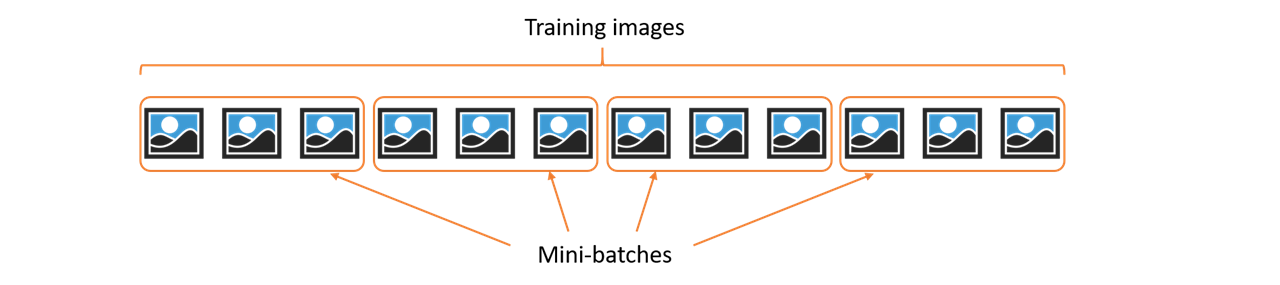

# Evaluate
Probemos los datos en el conjunto de test.

¿Qué predice el modelo para la imagen anterior?

Al haber entrenado con mini-batches, la entrada a la red es un tensor de tamaño `[batch_size, image_width, image_height, number_of_channels]`  
Al predecir, tenemos que respetar este tamaño aunque solo usemos una imagen. Puedes expandir la dimensión con la función de numpy `expand_dims`

¿Qué predice la red para la imagen anterior?

# Image data generator

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

In [ ]:
example_df = df.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
)

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
train_df, validate_df = train_test_split(df.sample(5500),
                                         test_size=500,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print("Shape train", total_train)
print("Shape validation", total_validate)
validate_df.head()

In [ ]:
train_df.head()

In [ ]:
train_df.category.value_counts()

# Training Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

### Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

# Fit Model

In [ ]:
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator
)

In [ ]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

## Guardar el modelo

In [ ]:
model.save_weights("model.h5")

## Predecir nuevas imágenes